
# Fuzzy C-Means (FCM) Clustering — Beginner-Friendly Notebook

Welcome! This notebook walks you through the **Fuzzy C-Means (FCM)** clustering algorithm step by step using pure NumPy — no external libraries required.  
You'll learn how to:
- Generate a simple 2D dataset
- Implement FCM from scratch
- Run FCM and interpret the results
- Visualize clusters and fuzzy memberships

> Tip: You can edit the parameters (like the number of clusters) in the cells below and re-run them to see how the output changes.


In [1]:

import numpy as np
import matplotlib.pyplot as plt

# For reproducibility
rng = np.random.default_rng(42)



## 1. Create a simple dataset

We'll create a small 2D dataset made of three blob-like clusters to make the result easy to see.


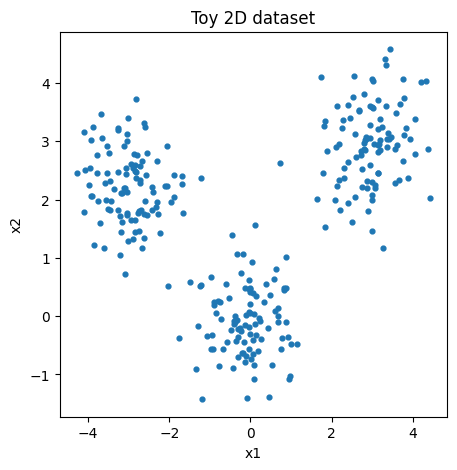

In [2]:

def make_blobs(n_per_cluster=80, centers=None, spread=0.6, random_state=42):
    """
    Minimal 'make_blobs' using NumPy only.
    centers: list of 2D coordinates for cluster centers, e.g. [(0,0), (3,3), (-3,2)]
    """
    if centers is None:
        centers = [(0, 0), (3.0, 3.0), (-3.0, 2.5)]
    rng_local = np.random.default_rng(random_state)
    X_parts = []
    for cx, cy in centers:
        X_parts.append(rng_local.normal(loc=(cx, cy), scale=spread, size=(n_per_cluster, 2)))
    X = np.vstack(X_parts)
    return X

X = make_blobs(n_per_cluster=100, centers=[(0,0), (3,3), (-3,2.5)], spread=0.7, random_state=7)

plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], s=12)
plt.title("Toy 2D dataset")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()



## 2. What is Fuzzy C-Means? (Quick intuition)

**Fuzzy C-Means** is like K-Means, but instead of assigning each point to exactly one cluster,  
it assigns **degrees of membership** (numbers between 0 and 1) to all clusters.  
- The memberships for a point sum to 1 across clusters.
- The fuzziness is controlled by the parameter **m** (usually 2.0).  
- We iteratively update cluster **centers** and **memberships** until convergence.



## 3. FCM implementation (from scratch)

Below is a clean, well-commented implementation of FCM using only NumPy.


In [3]:

def _initialize_membership(n_samples, n_clusters, rng):
    """Randomly initialize membership matrix U with rows summing to 1."""
    U = rng.random((n_samples, n_clusters))
    U = U / U.sum(axis=1, keepdims=True)
    return U

def _compute_centers(X, U, m):
    """Compute cluster centers given data X and membership matrix U with fuzzifier m."""
    Um = U ** m  # (n, c)
    numerator = Um.T @ X                 # (c, 2)
    denominator = Um.sum(axis=0)[:,None] # (c, 1)
    # Avoid divide-by-zero
    denominator = np.where(denominator == 0, 1e-12, denominator)
    centers = numerator / denominator
    return centers

def _distance_matrix(X, centers):
    """Compute squared Euclidean distance from each point to each center. Returns (n, c)."""
    diffs = X[:,None,:] - centers[None,:,:]
    dist2 = np.sum(diffs * diffs, axis=2)  # (n, c)
    return dist2

def _update_membership(dist2, m):
    """
    Update membership U using distances.
    If a point sits exactly on a center (dist=0), assign full membership to that cluster.
    """
    n, c = dist2.shape
    eps = 1e-12
    dist2 = np.maximum(dist2, eps)

    power = 1.0 / (m - 1.0)
    ratio = (dist2[:,:,None] / dist2[:,None,:]) ** power  # shape (n, c, c)
    denom = np.sum(ratio, axis=2)                          # (n, c)
    U_new = 1.0 / denom

    # Numerical safety: renormalize rows to sum to 1
    U_new = U_new / U_new.sum(axis=1, keepdims=True)
    return U_new

def fuzzy_c_means(X, n_clusters=3, m=2.0, max_iter=150, tol=1e-4, random_state=42, verbose=True):
    """
    Run Fuzzy C-Means on data X.
    Returns: centers, U (membership), labels (hard assignments), history (objective values)
    """
    rng_local = np.random.default_rng(random_state)
    n_samples = X.shape[0]
    U = _initialize_membership(n_samples, n_clusters, rng_local)

    history = []
    prev_J = np.inf

    for it in range(1, max_iter+1):
        centers = _compute_centers(X, U, m)
        dist2 = _distance_matrix(X, centers)
        J = np.sum((U ** m) * dist2)  # objective
        history.append(J)

        if verbose and (it % 10 == 0 or it == 1):
            print(f"Iter {it:3d} | Objective J = {J:.6f}")

        if np.abs(prev_J - J) < tol:
            if verbose:
                print(f"Converged at iter {it} (|ΔJ| < {tol})")
            break
        prev_J = J

        U = _update_membership(dist2, m)

    labels = np.argmax(U, axis=1)
    return centers, U, labels, history



## 4. Run FCM on the dataset
Edit the parameters below and re-run to experiment.


Iter   1 | Objective J = 1061.711725
Iter  10 | Objective J = 208.196504
Converged at iter 11 (|ΔJ| < 1e-05)
Centers:
 [[-3.0008933   2.22475492]
 [ 2.98246628  2.97310494]
 [-0.08656863 -0.0820329 ]]
U shape: (300, 3) (n_samples x n_clusters)
First 5 membership rows:
 [[0.007 0.006 0.987]
 [0.018 0.013 0.969]
 [0.026 0.017 0.957]
 [0.082 0.07  0.848]
 [0.013 0.008 0.979]]


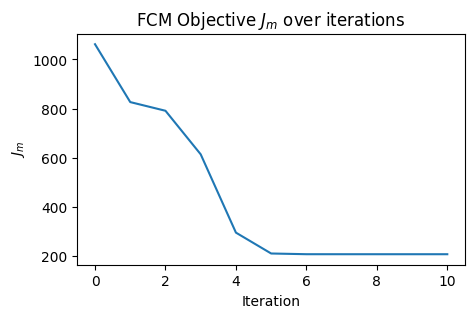

In [4]:

# ==== Parameters you can tweak ====
n_clusters = 3   # try 2, 3, 4, ...
m = 2.0          # fuzziness (usually in [1.5, 2.5]); must be > 1
max_iter = 200
tol = 1e-5
random_state = 7
verbose = True
# ==================================

centers, U, labels, history = fuzzy_c_means(
    X, n_clusters=n_clusters, m=m, max_iter=max_iter, tol=tol,
    random_state=random_state, verbose=verbose
)

print("Centers:\n", centers)
print("U shape:", U.shape, "(n_samples x n_clusters)")
print("First 5 membership rows:\n", np.round(U[:5], 3))

plt.figure(figsize=(5,3))
plt.plot(history)
plt.title("FCM Objective $J_m$ over iterations")
plt.xlabel("Iteration")
plt.ylabel("$J_m$")
plt.show()



## 5. Visualize results

We'll plot the data with **hard labels** (choose the cluster with the highest membership).  
The centers are shown as larger markers. Then, we'll also visualize the membership for one cluster.


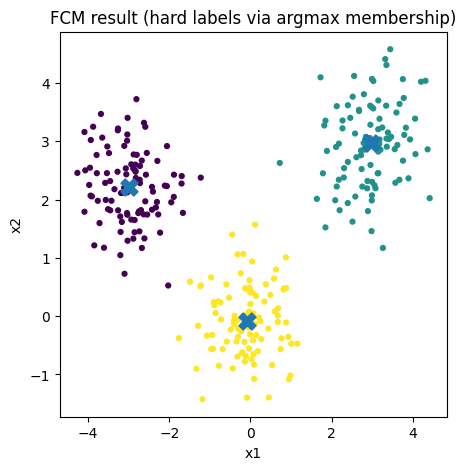

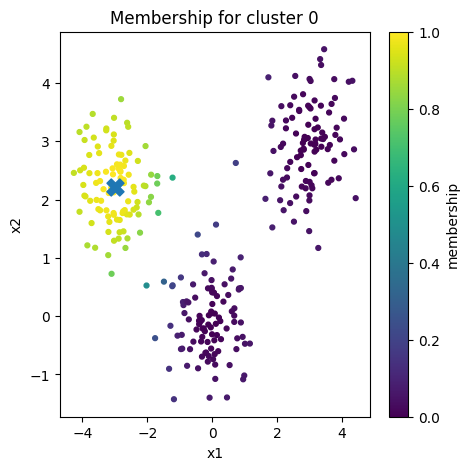

In [5]:

# Hard labels visualization
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], s=12, c=labels)
plt.scatter(centers[:,0], centers[:,1], s=150, marker='X')
plt.title("FCM result (hard labels via argmax membership)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

# Membership heat for cluster 0
cluster_to_show = 0
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], s=12, c=U[:, cluster_to_show])
plt.scatter(centers[cluster_to_show,0], centers[cluster_to_show,1], s=150, marker='X')
plt.title(f"Membership for cluster {cluster_to_show}")
plt.xlabel("x1")
plt.ylabel("x2")
plt.colorbar(label="membership")
plt.show()



## 6. Classifying new points (using learned centers)

After fitting FCM, you can compute memberships for **new** points using the final centers.


In [6]:

def fcm_predict_membership(X_new, centers, m=2.0):
    """
    Compute fuzzy memberships for new data given learned centers.
    Returns U_new of shape (n_new, n_clusters).
    """
    dist2 = _distance_matrix(X_new, centers)
    U_new = _update_membership(dist2, m)
    return U_new

# Example: predict memberships for 3 new points
X_new = np.array([[0.0, 0.0],
                  [2.5, 2.8],
                  [-3.0, 2.0]])

U_new = fcm_predict_membership(X_new, centers, m=m)
print("New points:\n", X_new)
print("Memberships:\n", np.round(U_new, 3))
print("Hard labels:", np.argmax(U_new, axis=1))


New points:
 [[ 0.   0. ]
 [ 2.5  2.8]
 [-3.   2. ]]
Memberships:
 [[0.001 0.001 0.998]
 [0.008 0.975 0.017]
 [0.995 0.001 0.004]]
Hard labels: [2 1 0]



## 7. Practical tips & next steps

- **Number of clusters**: Try different values and compare objective values and visualizations.
- **Fuzziness `m`**: Commonly set to 2.0. Larger values produce "softer" memberships.
- **Scaling**: For real datasets with very different feature scales, consider standardizing features first.
- **Stopping**: Convergence checks use the change in the objective `J_m`. You can adjust `tol` for stricter/looser stopping.
- **From scratch vs. library**: This notebook uses pure NumPy for clarity. For advanced use, look into implementations in libraries like `scikit-fuzzy`.

Happy clustering!
